In [1]:
# TO check the Average Price of IntraYear trading

In [16]:
from import_library import *

In [17]:
def Colab(mainFile):
    from google.colab import drive
    drive.mount('/content/drive')
    dir = '/content/drive/MyDrive/Example/Stock/'
    df = pd.read_csv(dir+mainFile, sep=',',header = 0)
    return df 

# Configuration

In [53]:
SEED = 42
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
NUM_WORKERS = 4
BATCH_SIZE = 8 # 64
PIN_MEMORY = True
LOAD_MODEL = False
LEARNING_RATE = 1e-4
NUM_EPOCHS = 100

In [54]:
# mainFile = 'KHP Historical Data.csv'
mainFile = 'SBT Historical Data.csv'
# Colab
# df_raw = Colab(mainFile)
# Local
df_raw = pd.read_csv(mainFile, sep=',',header = 0)
df_raw.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,06/28/2019,"15,206.1","14,852.5","15,206.1","14,852.5",1.39M,0.58%
1,06/27/2019,"15,117.7","15,161.9","15,161.9","14,985.1",1.30M,-0.29%
2,06/26/2019,"15,161.9","15,161.9","15,161.9","15,029.3",1.28M,0.00%
3,06/25/2019,"15,161.9","15,161.9","15,161.9","14,985.1",1.27M,0.00%
4,06/24/2019,"15,161.9","14,985.1","15,206.1","14,985.1",1.98M,0.29%


# Data Wrangling

## Function

In [29]:
### Data_Wrangling.py
def DropNanValue(df,features):
  '''
  Drop nan Value
  ----------
  Attributes:
  df : pd.DataFrame
  features: list
      List of features
  ----------
  Returns:
  df : pd.DataFrame
  ----------
  Example:
  feautures =['Date','Vol.','Price']
  NaProcessed_df = DropNanValue(df,feautures)
  df.isnull().sum()
  '''
  to_delete = []
  for feature in features:
    condition = df[feature].isnull()
    if len(df[condition] != 0):
      idx = df[condition].index[0]
      to_delete.append(idx)
    df = df.drop(to_delete)
    df.reset_index(drop=True,inplace=True)
  return df

### Data_Transformation.py
def TransformCommaToColons(input):
    return float(input.replace(',',''))/1000

def VolumeTransformation(input):
  '''
    Volume Transformation
    ----------
    Attributes:
    input : DataLoader
    model : pytorch model
    device : using GPU
    ----------
    Returns:
    acc: accuracy value
    ----------
    Example:
    check_accuracy(val_loader, model, DEVICE)
    input = df['Vol.'][0]
    input = input[:-1]
    millions = input.split('.')[0]
    thousand_hundreds = input.split('.')[1][0]
    thousand_tens = input.split('.')[1][1]
    volume = float(millions)*1e6 + float(thousand_hundreds)*1e5 + float(thousand_tens)*1e4
    volume
  '''
  if input[-1] == "M":
    # 87.21M
    input = input[:-1]
    millions = input.split('.')[0]
    thousand_hundreds = input.split('.')[1][0]
    thousand_tens = input.split('.')[1][1]
    volume = float(millions)*1e6 + float(thousand_hundreds)*1e5 + float(thousand_tens)*1e4
  else:
    # 589.32K
    input = input[:-1]
    thousands = input.split('.')[0]
    hundreds = input.split('.')[1][0]
    tens = input.split('.')[1][1]
    volume = float(thousands)*1e3 + float(hundreds)*1e2 + float(tens)*1e1
  return volume

# Run code

In [55]:
chosedColumns =['Date','Vol.','Price']
df = df_raw[chosedColumns]
df = DropNanValue(df, chosedColumns)

In [56]:
# Convert the type of all comlumns # Date --> Time/ Volumn+Close --> Integer
# Convert M - k into number
df['Vol.'] = df['Vol.'].apply(VolumeTransformation)
df['Price'] = df['Price'].apply(TransformCommaToColons)
df['Date'] = pd.to_datetime(df['Date'],format='%m/%d/%Y')
#df['Month'] = df['Date'].dt.strftime('%m-%Y')
df = df.sort_values(by='Date', ascending=True).reset_index(drop=True)

In [57]:
df

,Date,Vol.,Price
0,2018-07-02,2240000.00,11.82
1,2018-07-03,2050000.00,12.02
2,2018-07-04,1480000.00,12.02
3,2018-07-05,2390000.00,12.02
4,2018-07-06,1500000.00,12.18
...,...,...,...
243,2019-06-24,1980000.00,15.16
244,2019-06-25,1270000.00,15.16
245,2019-06-26,1280000.00,15.16
246,2019-06-27,1300000.00,15.12


In [58]:
df['mul'] = df['Vol.']*df['Price']

In [59]:
mul = df['mul'].sum()
vol = df['Vol.'].sum()
mul/vol

16.18266064290729

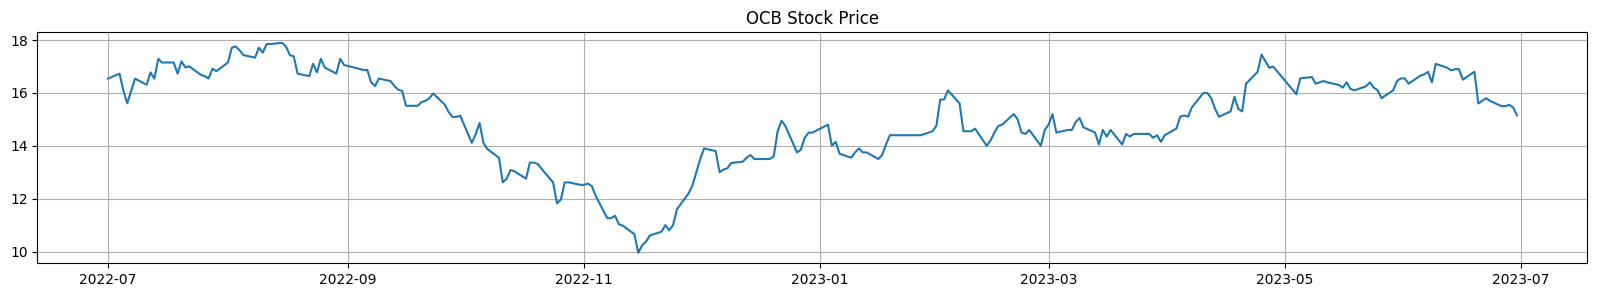

In [11]:
#data 633 x 4
plt.figure(figsize=(20,3))
plt.plot(df['Date'],df['Price'])
plt.title('OCB Stock Price')
plt.grid()
#_ = plt.xticks(df.index.values, df['Month'], rotation=60)
plt.show()

In [12]:
def DataSplitting(df,TrainRatio=0.9):
  '''
  Split data
  ----------
  Attributes:
  df : pd.DataFrame
  TrainRatio: float, default = 0.9
      train split ratio
  ----------
  Returns:
  dataset : pd.DataFrame
  splittingIndex: float
      splitting index
  ----------
  Example:
  dataset, splittingIndex = DataSplitting(df)
  '''
  # Create a new dataframe with only the 'Closed column
  data = df['Price']
  # Convert the dataframe to a numpy array
  dataset = data.values
  # Get the number of rows to train the model on --> Split the dataset
  splittingIndex = int(np.ceil(len(dataset)*TrainRatio))
  return dataset, splittingIndex

def create_dataset(dataset, lookback):
  '''
  Transform timeseries into a prediction dataset
  ----------
  Args:
   dataset: A np array of times series,
   lookback: size of window for prediction
  ----------
  Example:
  lookback = 20
  X_train, y_train = create_dataset(dataset,lookback)
  X_test y_test = create_dataset(dataset,lookback)
  '''
  X, y = [], []
  for i in range(len(dataset) - lookback):
    # Time series feature
    feature = dataset[i:i+lookback]
    # the Target is the next value
    target = dataset[i+1:i+lookback+1]
    X.append(feature)
    y.append(target)
  X = torch.tensor(X).unsqueeze(-1)
  y = torch.tensor(y).unsqueeze(-1)
  return X,y



In [13]:
class LSTM_model(nn.Module):
  '''
  Long-Short Term Memory with 1 LSTM and 1 NN as classifier
  if batch first --> input (batch, seq, feature) - (8,20,1)
  '''
  def __init__(self, input_dim=1, hidden_size=50, num_layers=1):
    super(LSTM_model,self).__init__()
    self.input_dim= input_dim
    self.hidden_size= hidden_size
    self.num_layers = num_layers
    self.lstm = nn.LSTM(input_size=self.input_dim, hidden_size=self.hidden_size, num_layers=self.num_layers, batch_first=True)
    # Classifier #  linear transformation, in_feature =50, out_one =1
    self.linear = nn.Linear(self.hidden_size,1)

  def forward(self,x):
    x,_ = self.lstm(x)
    x = self.linear(x)
    return x


class Conv_LSTM(nn.Module):
  '''
  2 Conv1D + LSTM with 1 LSTM and 1 NN as classifier
  if batch first --> input (batch, seq, feature) - (8,20,1)- input (batch, seq, feature) - (8,20,1) - out torch.Size([8, 4, 1])
  x torch.Size([8, 1, 20])
  p torch.Size([8, 50, 4])
  output torch.Size([8, 4, 50])
  output torch.Size([8, 4, 1])
  '''
  def __init__(self, input_size=1, hidden_size=50, output_size= 1, num_layers=1):
    super(Conv_LSTM,self).__init__()
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.output_size = output_size
    self.num_layers = num_layers
    # ConV - 2
    self.c1 = nn.Conv1d(input_size, hidden_size, 2)
    self.p1 = nn.AvgPool1d(2)
    self.c2 = nn.Conv1d(hidden_size, hidden_size, 1)
    self.p2 = nn.AvgPool1d(2)
    # LSTM
    self.lstm = nn.LSTM(input_size=self.hidden_size, hidden_size=self.hidden_size, num_layers=self.num_layers, batch_first=True)

    # Classifier #  linear transformation, in_feature =50, out_one =1
    self.linear = nn.Linear(self.hidden_size,self.output_size)


  def forward(self,x):    # ((8,20,1))
    x = x.transpose(1, 2) # torch.Size([8, 1, 20])
    # print('x',x.size())
        # Run through Conv1d and Pool1d layers: Conv1d+AvgPool -> Conv2d+AvgPool
    c = self.c1(x)
    p = self.p1(c)
    c = self.c2(p)
    p = self.p2(c)
    #print('p',p.size()) # torch.Size([8,50, 4])
    p = p.transpose(1, 2) # torch.Size([8,4, 50])
    output, _ = self.lstm(p)
    # print('output',output.size()) # torch.Size([8,4, 50])
    output = self.linear(output)
    # print('output',output.size()) # torch.Size([8,4, 1])
    return output


def test_model():
  '''
  # 8 - batch_size
  # 20- feature- lookback
  # 1 - series out of 8
  # test_model()
  '''
  x = torch.randn((8,20,1))
  model = LSTM_model()
  preds = model(x)
  print('x.shape',x.shape)
  print(preds.shape)

# test_model()
# x.shape torch.Size([8, 20, 1])
# torch.Size([8, 20, 1])

In [14]:
def train_fn(loader, model, optimizer, loss_fn, scaler,device):
    '''
    Training process
    model = MODEL().to(DEVICE)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    scaler = torch.cuda.amp.GradScaler()

    for epoch in range(NUM_EPOCHS):
      train_fn(trainLoader, model, optimizer, loss_fn, scaler,DEVICE)
    '''
    model.train()
    loop = tqdm(loader)
    running_loss =0
    for batch_idx, (data, targets) in enumerate(loop):
      # Get data to cuda if possible
      data = data.float().to(device=device)
      # Convert to the float and unsqueeze is reshape the target --> just 1 dimension
      targets = targets.float().to(device=device)
      # forward
      with torch.cuda.amp.autocast():
        '''
        Instances of torch.autocast enable autocasting for chosen regions.
        Autocasting automatically chooses the precision for GPU operations
        to improve performance while maintaining accuracy.
        '''
        preds = model(data)
        loss = loss_fn(preds, targets) #
        running_loss += loss.item()

      # backward
      optimizer.zero_grad()
      # Scales loss.  Calls backward() on scaled loss to create scaled gradients.
      # Backward passes under autocast are not recommended.
      # Backward ops run in the same dtype autocast chose for corresponding forward ops.
      scaler.scale(loss).backward()
      # scaler.step() first unscales the gradients of the optimizer's assigned params.
      # If these gradients do not contain infs or NaNs, optimizer.step() is then called,
      # otherwise, optimizer.step() is skipped.
      scaler.step(optimizer)
      # Updates the scale for next iteration.
      scaler.update()

      # update tqdm loop
      loop.set_postfix(loss=loss.item())

    return running_loss

def val_fn(loader, model, loss_fn,device):
    '''
    Training process
    model = MODEL().to(DEVICE)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    scaler = torch.cuda.amp.GradScaler()

    for epoch in range(NUM_EPOCHS):
      train_fn(trainLoader, model, optimizer, loss_fn, scaler,DEVICE)
    '''
    model.eval()
    running_loss =0
    for data, targets in loader:
      # Get data to cuda if possible
      data = data.float().to(device=device)
      targets = targets.float().to(device=device)

      # forward
      with torch.cuda.amp.autocast():
        preds = model(data)
        loss = loss_fn(preds, targets) #
        running_loss += loss.item()
    return running_loss

In [15]:
def train_fn_C_LSTM(loader, model, optimizer, loss_fn, scaler,device):
    '''
    Training process
    model = MODEL().to(DEVICE)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    scaler = torch.cuda.amp.GradScaler()

    for epoch in range(NUM_EPOCHS):
      train_fn(trainLoader, model, optimizer, loss_fn, scaler,DEVICE)
    '''
    model.train()
    loop = tqdm(loader)
    running_loss =0
    for batch_idx, (data, targets) in enumerate(loop):
      # Get data to cuda if possible
      data = data.float().to(device=device)
      # Convert to the float and unsqueeze is reshape the target --> just 1 dimension
      targets = targets.float().to(device=device)
      # forward
      with torch.cuda.amp.autocast():
        '''
        Instances of torch.autocast enable autocasting for chosen regions.
        Autocasting automatically chooses the precision for GPU operations
        to improve performance while maintaining accuracy.
        '''
        preds = model(data)
        loss = loss_fn(preds, targets) #
        running_loss += loss.item()

      # backward
      optimizer.zero_grad()
      # Scales loss.  Calls backward() on scaled loss to create scaled gradients.
      # Backward passes under autocast are not recommended.
      # Backward ops run in the same dtype autocast chose for corresponding forward ops.
      scaler.scale(loss).backward()
      # scaler.step() first unscales the gradients of the optimizer's assigned params.
      # If these gradients do not contain infs or NaNs, optimizer.step() is then called,
      # otherwise, optimizer.step() is skipped.
      scaler.step(optimizer)
      # Updates the scale for next iteration.
      scaler.update()

      # update tqdm loop
      loop.set_postfix(loss=loss.item())

    return running_loss

def val_fn_C_LSTM(loader, model, loss_fn,device):
    '''
    Training process
    model = MODEL().to(DEVICE)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    scaler = torch.cuda.amp.GradScaler()

    for epoch in range(NUM_EPOCHS):
      train_fn(trainLoader, model, optimizer, loss_fn, scaler,DEVICE)
    '''
    model.eval()
    running_loss =0
    for data, targets in loader:
      # Get data to cuda if possible
      data = data.float().to(device=device)
      targets = targets.float().to(device=device)

      # forward
      with torch.cuda.amp.autocast():
        preds = model(data)
        loss = loss_fn(preds, targets) #
        running_loss += loss.item()
    return running_loss